### Use RBM to perform feature extraction on an image-based dataset that you find or create. If you go this route, present the features you extract and explain why this is a useful feature extraction method in the context you’re operating in.

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from skimage.transform import resize

warnings.filterwarnings(action ='ignore', module='sklearn')

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [11]:
X = []
y = []
for directory, _, file in os.walk('data/rockpaperscissors'):
    for f in file:
        f = os.path.join(directory, f)
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = resize(img, (150, 150, 1))
            img = np.asarray(img)
            label=f.split('/')[-2]
            X.append(img)
            y.append(label)

In [12]:
X, X_test = train_test_split(X, random_state = 3)
y, y_test = train_test_split(y, random_state = 3)

X2 = []
for i in range(len(X)):
    a = X[i].flatten()
    X2.append(a)
    
X2 = np.asarray(X2)

X_test2 = []
for i in range(len(X_test)):
    a = X_test[i].flatten()
    X_test2.append(a)
    
X_test2 = np.asarray(X_test2)

In [53]:
# initialize the RBM + Logistic Regression pipeline
rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])
params = {
    "rbm__learning_rate": [0.01, 0.001],
    "rbm__n_iter": [20, 100],
    "rbm__n_components": [100],
    "logistic__C": [1.0, 10.0, 100.0]}

# perform a grid search over the parameter
gs = GridSearchCV(classifier, params, cv = 3, n_jobs = -1, verbose = 1)
gs.fit(X2, y)

print("Best Score: %0.3f" % (gs.best_score_))

print("RBM + Logistic Regression parameters")
bestParams = gs.best_estimator_.get_params()

# loop over the parameters and print each of them out
# so they can be manually set
for p in sorted(params.keys()):
    print("\t %s: %f" % (p, bestParams[p]))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 1137.0min finished


Best Score: 0.676
RBM + Logistic Regression parameters
	 logistic__C: 10.000000
	 rbm__learning_rate: 0.001000
	 rbm__n_components: 100.000000
	 rbm__n_iter: 100.000000


In [72]:
# Using BernoulliRBM and LogisticRegression with our optimized parameters
rbm = BernoulliRBM(learning_rate = .001, n_components = 100, n_iter = 100)
logistic = LogisticRegression(C = 10, n_jobs = -1)
classifier = Pipeline(steps = [("rbm", rbm), ("logistic", logistic)])
# Fitting to the RBM/Logistic pipeline
classifier.fit(X2, y)

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.001,
                              n_components=100, n_iter=100, random_state=None,
                              verbose=0)),
                ('logistic',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='warn',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [67]:
# using just the logistic regression model
raw_pixel = clone(logistic)
raw_pixel.C = 100
raw_pixel.fit(X2, y)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
from sklearn import metrics

# prediction of the rbm and logistic pipeline
y_pred = classifier.predict(X_test2)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       paper       0.39      0.29      0.33       184
        rock       0.51      0.33      0.40       190
    scissors       0.38      0.63      0.47       173

    accuracy                           0.41       547
   macro avg       0.43      0.41      0.40       547
weighted avg       0.43      0.41      0.40       547



In [69]:
# prediction of the logistic pipeline alone
y_pred_pixel = raw_pixel.predict(X_test2)
print(metrics.classification_report(y_test, y_pred_pixel))

              precision    recall  f1-score   support

       paper       0.72      0.55      0.63       184
        rock       0.63      0.76      0.69       190
    scissors       0.58      0.59      0.58       173

    accuracy                           0.64       547
   macro avg       0.64      0.63      0.63       547
weighted avg       0.64      0.64      0.63       547



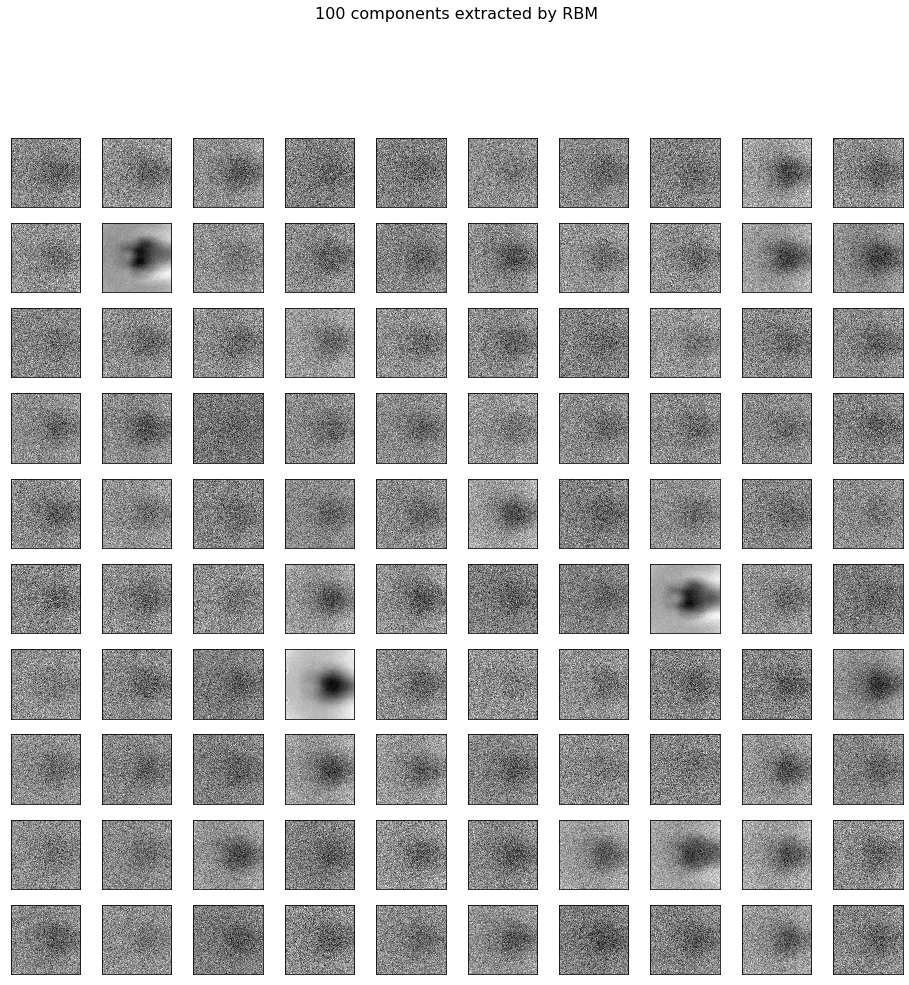

In [74]:
plt.figure(figsize=(15, 14))
for i, component in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(component.reshape(150, 150), cmap = plt.cm.gray_r,
               interpolation = 'nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

Our pipeline model doesn't work super well - it only has 40% accuracy. Since the data is about equally split into three groups, this shows our model works ever so slightly. The features that it ends up using are interesting. It seems to be taking random parts of the picture rather than number of fingers presented, as a humna would. I'm not certain why these features are useful, but apparently they are twice as good as guessing.